# Kaggle - Facebook recruiting

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import time
import seaborn as sns 
import os
%matplotlib inline
os.chdir('E:\\Google Drive\\kaggle\\03-facebook\\data')

## Part 1 - Loading data
This will include sampling the data to 1M rows in case we want to do anything computationally tricky.

In [3]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_train.head()

,row_id,x,y,accuracy,time,place_id
0,0,0.7941,9.0809,54,470702,8523065625
1,1,5.9567,4.7968,13,186555,1757726713
2,2,8.3078,7.0407,74,322648,1137537235
3,3,7.3665,2.5165,65,704587,6567393236
4,4,4.0961,1.1307,31,472130,7440663949


In [4]:
# Sample them for quicker visualisations
df_train_sample = df_train.sample(n=1000000)
df_test_sample = df_test.sample(n=1000000)

## Part 2 - Quick visualisations
Let's start with some basic histograms, showing the distribution of accuracy and time.

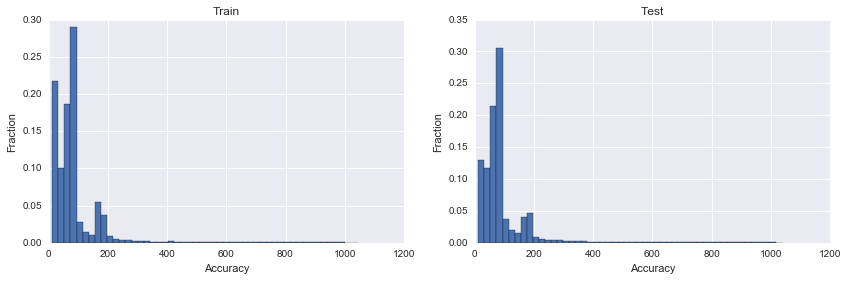

In [5]:
counts1, bins1 = np.histogram(df_train["accuracy"], bins=50)
binsc1 = bins1[:-1] + np.diff(bins1)/2.

counts2, bins2 = np.histogram(df_test["accuracy"], bins=50)
binsc2 = bins2[:-1] + np.diff(bins2)/2.

plt.figure(0, figsize=(14,4))

plt.subplot(121)
plt.bar(binsc1, counts1/(counts1.sum()*1.0), width=np.diff(bins1)[0])
plt.grid(True)
plt.xlabel("Accuracy")
plt.ylabel("Fraction")
plt.title("Train")

plt.subplot(122)
plt.bar(binsc2, counts2/(counts2.sum()*1.0), width=np.diff(bins2)[0])
plt.grid(True)
plt.xlabel("Accuracy")
plt.ylabel("Fraction")
plt.title("Test")

plt.show()

Accuracy has some interesting structure, but is relatively consistent across train/test.  
Check time distributions:

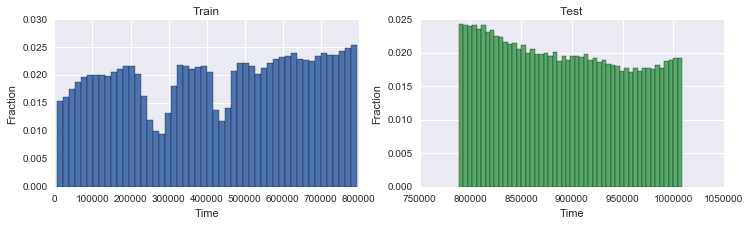

In [6]:
current_palette = sns.color_palette()

counts1, bins1 = np.histogram(df_train["time"], bins=50)
binsc1 = bins1[:-1] + np.diff(bins1)/2.

counts2, bins2 = np.histogram(df_test["time"], bins=50)
binsc2 = bins2[:-1] + np.diff(bins2)/2.

plt.figure(1, figsize=(12,3))

plt.subplot(121)
plt.bar(binsc1, counts1/(counts1.sum()*1.0), width=np.diff(bins1)[0], color=current_palette[0])
plt.grid(True)
plt.xlabel("Time")
plt.ylabel("Fraction")
plt.title("Train")

plt.subplot(122)
plt.bar(binsc2, counts2/(counts2.sum()*1.0), width=np.diff(bins2)[0], color=current_palette[1])
plt.grid(True)
plt.xlabel("Time")
plt.ylabel("Fraction")
plt.title("Test")

plt.show()

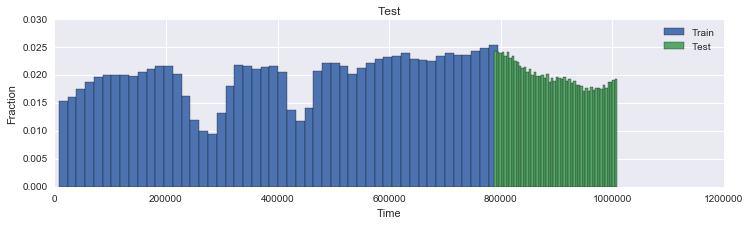

In [7]:
plt.figure(2, figsize=(12,3))
plt.bar(binsc1, counts1/(counts1.sum()*1.0), width=np.diff(bins1)[0], color=current_palette[0], label="Train")
plt.bar(binsc2, counts2/(counts2.sum()*1.0), width=np.diff(bins2)[0], color=current_palette[1], label="Test")
plt.grid(True)
plt.xlabel("Time")
plt.ylabel("Fraction")
plt.title("Test")
plt.legend()
plt.show()


The two dips of time in training set are curious, if looking at counts per unit time they might need to be normalised.  
Another thing we can look at is how frequently different locations appear.

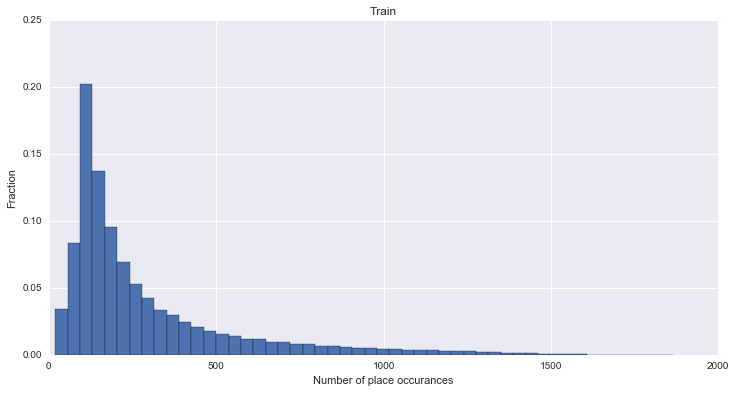

In [8]:
# Check how how frequently different locations appear
df_placecounts = df_train["place_id"].value_counts()

counts, bins = np.histogram(df_placecounts.values, bins=50)
binsc = bins[:-1] + np.diff(bins)/2.

plt.figure(3, figsize=(12,6))
plt.bar(binsc, counts/(counts.sum()*1.0), width=np.diff(bins)[0])
plt.grid(True)
plt.xlabel("Number of place occurances")
plt.ylabel("Fraction")
plt.title("Train")
plt.show()

OK, so most places appear around 100 times.  
Let's see if accuracy changes with "time" at all:

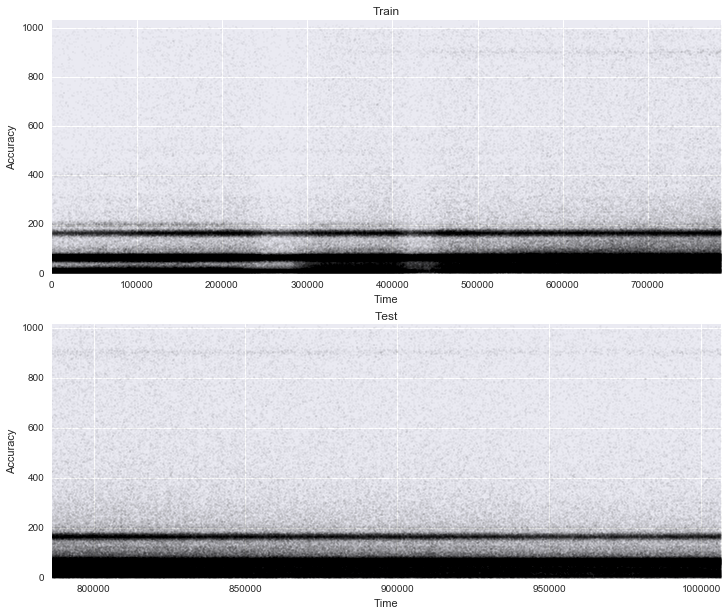

In [9]:
 # Check if accuracy of signal corresponds with time
plt.figure(4, figsize=(12,10))

plt.subplot(211)
plt.scatter(df_train_sample["time"], df_train_sample["accuracy"], s=1, c='k', lw=0, alpha=0.1)
plt.xlabel("Time")
plt.ylabel("Accuracy")
plt.xlim(df_train_sample["time"].min(), df_train_sample["time"].max())
plt.ylim(df_train_sample["accuracy"].min(), df_train_sample["accuracy"].max())
plt.title("Train")

plt.subplot(212)
plt.scatter(df_test_sample["time"], df_test_sample["accuracy"], s=1, c='k', lw=0, alpha=0.1)
plt.xlabel("Time")
plt.ylabel("Accuracy")
plt.xlim(df_test_sample["time"].min(), df_test_sample["time"].max())
plt.ylim(df_test_sample["accuracy"].min(), df_test_sample["accuracy"].max())
plt.title("Test")

plt.show()

Not really - but we can see the two time dips in the training plot, and this emphases that accuracy is somewhat perfentially banded.  
What about if the accuracy varies with location?

In [10]:
# Does the accuracy vary with location?  Check within 100x100m spots
df_train_sample["xround"] = df_train_sample["x"].round(decimals=1)
df_train_sample["yround"] = df_train_sample["y"].round(decimals=1)
df_groupxy = df_train_sample.groupby(["xround", "yround"]).agg({"accuracy":[np.mean, np.std]})
df_groupxy.head()

accuracy            
                     mean         std
xround yround                        
0      0.0      47.000000   27.849596
       0.1      96.105263  167.946869
       0.2      84.545455  108.877241
       0.3     129.541667  178.145026
       0.4      57.625000   40.754634

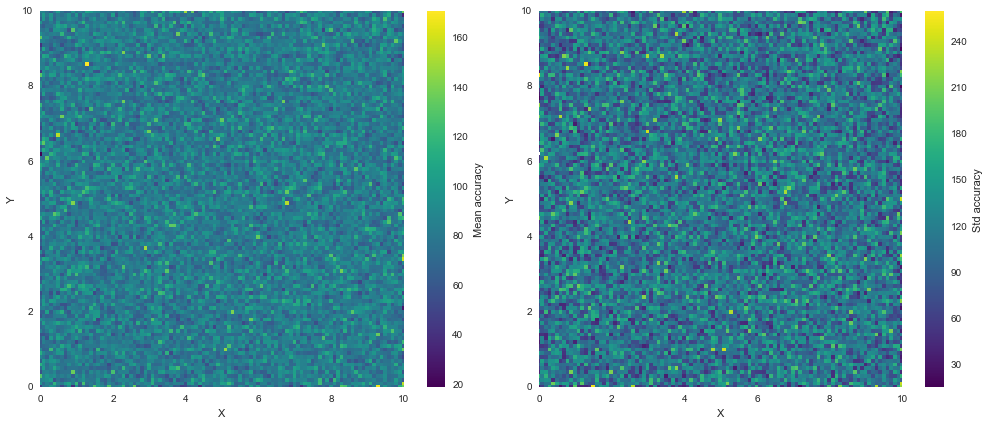

In [11]:
idx = np.asarray(list(df_groupxy.index.values))
plt.figure(5, figsize=(14,6))

plt.subplot(121)
plt.scatter(idx[:,0], idx[:,1], s=20, c=df_groupxy["accuracy", "mean"], marker='s', lw=0, cmap=plt.cm.viridis)
plt.colorbar().set_label("Mean accuracy")
plt.grid(True)
plt.xlabel("X")
plt.ylabel("Y")
plt.xlim(0,10)
plt.ylim(0,10)

plt.subplot(122)
plt.scatter(idx[:,0], idx[:,1], s=20, c=df_groupxy["accuracy", "std"], marker='s', lw=0, cmap=plt.cm.viridis)
plt.colorbar().set_label("Std accuracy")
plt.grid(True)
plt.xlabel("X")
plt.ylabel("Y")
plt.xlim(0,10)
plt.ylim(0,10)

plt.tight_layout()
plt.show()

No major structure here.

## Part 3 - Exploring places and times
For the next parts, I've created a list of the top places (by check in counts), and chosen the top 20 to investigate further.

In [12]:
# Get a list of the top 20 places for future reference
df_topplaces = df_placecounts.iloc[0:20]
l_topplaces = list(df_topplaces.index)
print(l_topplaces)

[8772469670, 1623394281, 1308450003, 4823777529, 9586338177, 9129780742, 9544215131, 5351837004, 4638096372, 8610202964, 6051554924, 7363774279, 8607353836, 8336299754, 5204012807, 7230349735, 7985287621, 4371034975, 4993591840, 7348940462]


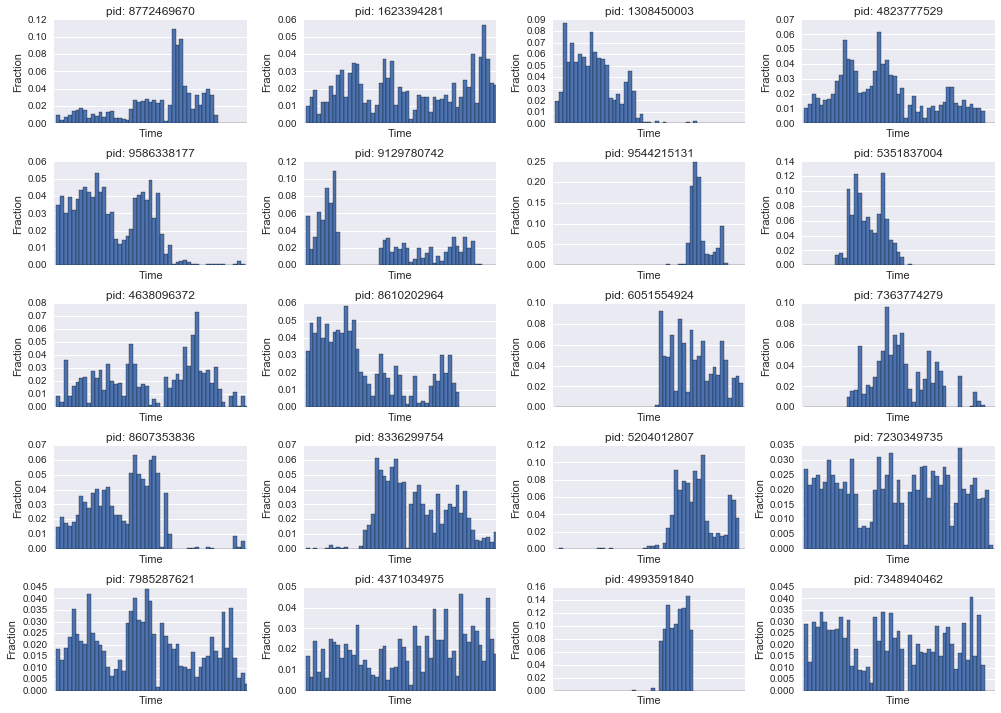

In [13]:
# Check if any of the top places have time correlated visits
plt.figure(6, figsize=(14,10))
for i in range(len(l_topplaces)):
    place = l_topplaces[i]

    df_place = df_train[df_train["place_id"]==place]

    counts, bins = np.histogram(df_place["time"], bins=50, range=[df_train["time"].min(), df_train["time"].max()])
    binsc = bins[:-1] + np.diff(bins)/2.
    
    plt.subplot(5,4,i+1)
    plt.bar(binsc, counts/(counts.sum()*1.0), width=np.diff(bins)[0])
    plt.xlim(df_train["time"].min(), df_train["time"].max())
    plt.grid(True)
    plt.xlabel("Time")
    plt.ylabel("Fraction")
    plt.gca().get_xaxis().set_ticks([])
    plt.title("pid: " + str(place))
    
plt.tight_layout()
plt.show()

Well, some places are visited at certain time periods for sure, but can't do much else until we disentangle time.  

The time interval in train goes from 1 - 800,000, presumably we can modulo these times to view cyclic nature (hours of days, days of week, etc).  
The best guess is seconds or minutes, which would equate to the training spanning 9 or 555 days respectively.

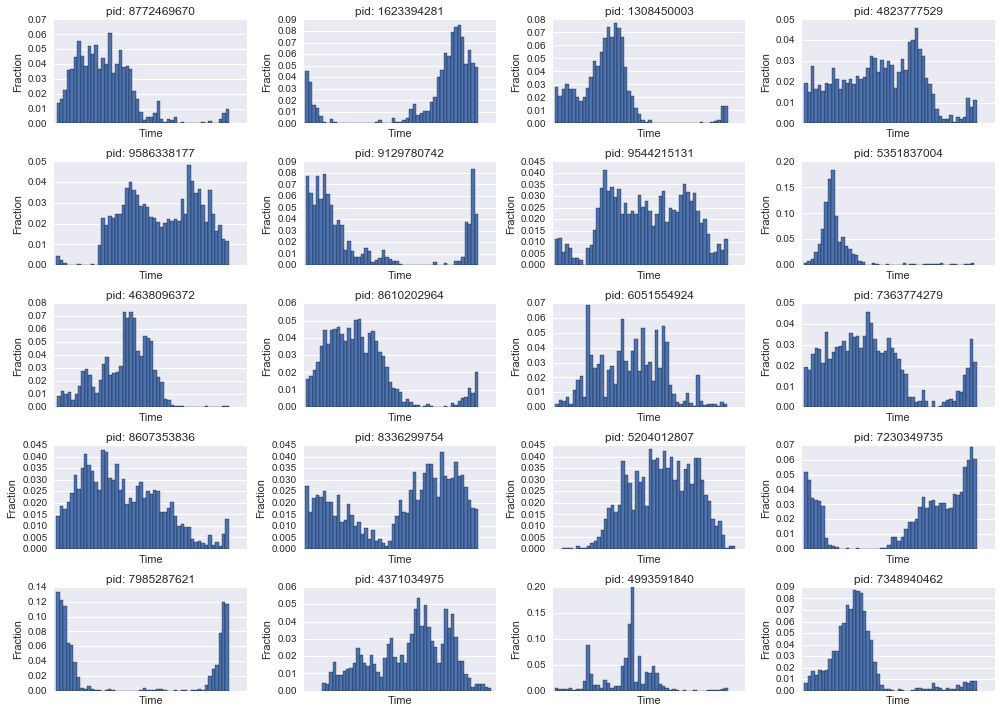

In [14]:
# Try to infer time
plt.figure(7, figsize=(14,10))
for i in range(len(l_topplaces)):
    place = l_topplaces[i]

    df_place = df_train[df_train["place_id"]==place]

    # Try % 3600*24 to see daily trend assuming it's in seconds
    # Try %   60*24 if minutes
    counts, bins = np.histogram(df_place["time"]%(60*24), bins=50)
    binsc = bins[:-1] + np.diff(bins)/2.
    
    plt.subplot(5,4,i+1)
    plt.bar(binsc, counts/(counts.sum()*1.0), width=np.diff(bins)[0])
    plt.grid(True)
    plt.xlabel("Time")
    plt.ylabel("Fraction")
    plt.gca().get_xaxis().set_ticks([])
    plt.title("pid: " + str(place))
    
plt.tight_layout()
plt.show()

Minutes looks pretty promising.  
This means we have ~555 days in train and ~140 in test.  
From this, we can look at day of week to identify trends (weekends), day (to find longer term seasonality).  
The next step is to add some columns representing our new time.  
Getting this exactly right (within the minute, so that "hours" are defined by clock hours, which probably correlate better with place visits) will probably be crucial later on, but as a first it doesn't matter if we're out by a bit.

In [15]:
# Add some columns to make calculations easier
df_train["hour"] = (df_train["time"]%(60*24))/60.
df_train["dayofweek"] = np.ceil((df_train["time"]%(60*24*7))/(60.*24))
df_train["dayofyear"] = np.ceil((df_train["time"]%(60*24*365))/(60.*24))
df_train.head()

,row_id,x,y,accuracy,time,place_id,hour,dayofweek,dayofyear
0,0,0.7941,9.0809,54,470702,8523065625,21.033333,5,327
1,1,5.9567,4.7968,13,186555,1757726713,13.250000,4,130
2,2,8.3078,7.0407,74,322648,1137537235,1.466667,1,225
3,3,7.3665,2.5165,65,704587,6567393236,7.116667,7,125
4,4,4.0961,1.1307,31,472130,7440663949,20.833333,6,328


In [16]:
df_train_sample["hour"] = (df_train_sample["time"]%(60*24))/60.
df_train_sample["dayofweek"] = np.ceil((df_train_sample["time"]%(60*24*7))/(60.*24))
df_train_sample["dayofyear"] = np.ceil((df_train_sample["time"]%(60*24*365))/(60.*24))

Look at the aggregate number of visits per weekday for the top 20 locations, this should show weekends, hopefully.

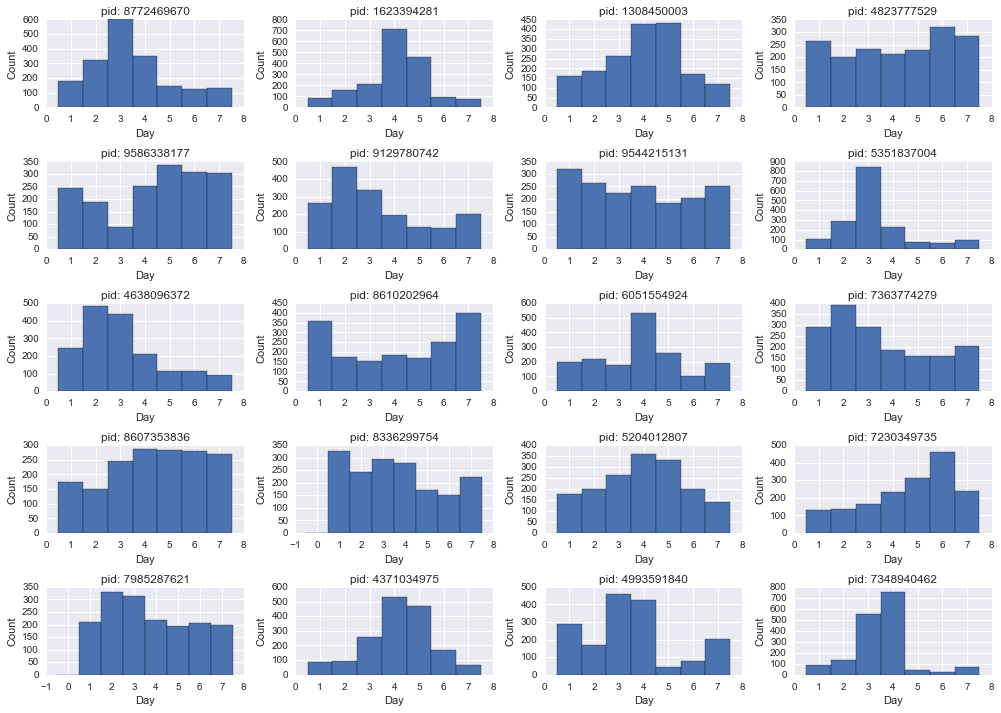

In [17]:
# Check the top 20 locations again for any weekly trends
plt.figure(8, figsize=(14,10))
for i in range(20):
    place = l_topplaces[i]
    df_place = df_train[df_train["place_id"]==place]

    # Group by weekday
    df_groupday = df_place.groupby("dayofweek").agg("count")

    plt.subplot(5,4,i+1)
    plt.bar(df_groupday.index.values-0.5, df_groupday["time"], width=1)
    plt.grid(True)
    plt.xlabel("Day")
    plt.ylabel("Count")
    plt.title("pid: " + str(place))
    
plt.tight_layout()
plt.show()


Some appear to have weekend-like behvaiour... what about looking at day of year.

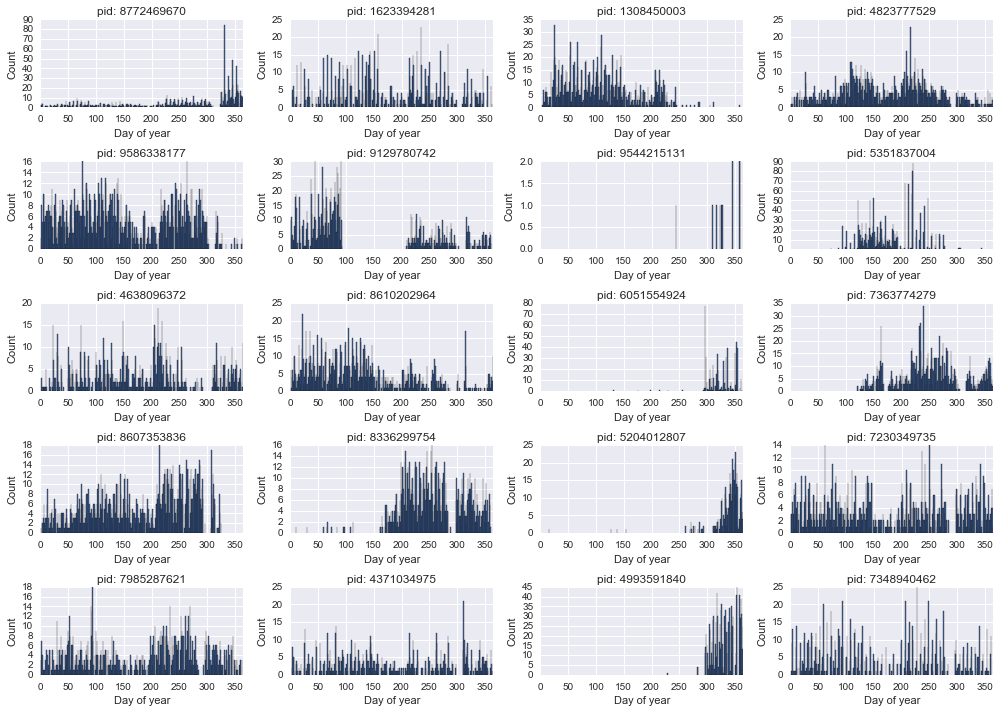

In [18]:
plt.figure(9, figsize=(14,10))
for i in range(20):
    place = l_topplaces[i]
    df_place = df_train[df_train["place_id"]==place]

    # Add some colums
    df_place = df_place[df_place["time"]<(60*24*365)] # Restrict to 1 year so the counts don't double up
    df_groupday = df_place.groupby("dayofyear").agg("count")

    plt.subplot(5,4,i+1)
    plt.bar(df_groupday.index.values-0.5, df_groupday["time"], width=1)
    plt.grid(True)
    plt.xlabel("Day of year")
    plt.ylabel("Count")
    plt.xlim(0,365)
    plt.title("pid: " + str(place))
    
plt.tight_layout()
plt.show()

Somewhat weird trends, looks like some of the top places only opened up business part way through.
The next interesting thing is to look at the distribution of (x,y) points for a given location:

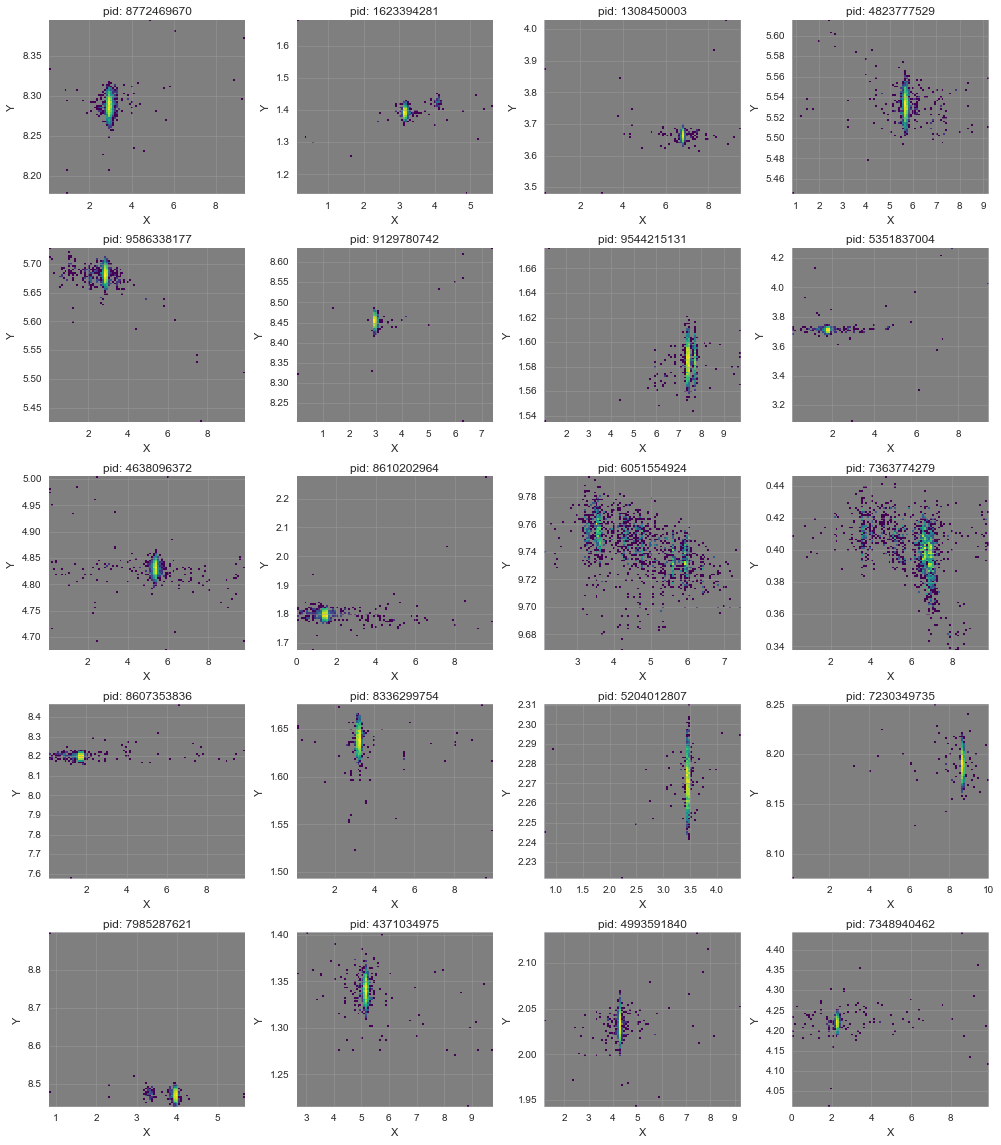

In [19]:
# Check the 2d distribution of (x,y) for the top 20 places
plt.figure(10, figsize=(14,16))
cmapm = plt.cm.viridis
cmapm.set_bad("0.5",1.)

for i in range(len(l_topplaces)):
    place = l_topplaces[i]
    df_place = df_train[df_train["place_id"]==place]
    counts, binsX, binsY = np.histogram2d(df_place["x"], df_place["y"], bins=100)
    extent = [binsX.min(),binsX.max(),binsY.min(),binsY.max()]

    plt.subplot(5,4,i+1)
    plt.imshow(np.log10(counts.T),
               interpolation='none',
               origin='lower',
               extent=extent,
               aspect="auto",
               cmap=cmapm)
    plt.grid(True, c='0.6', lw=0.5)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("pid: " + str(place))

plt.tight_layout()
plt.show()

The distributions are different for different locations, but many span a huge x-range relative to the y-range (maybe roads are aligned this way?)  
Let's re-visit the accuracy to see if it changes we get further away from the presumed centroid location:

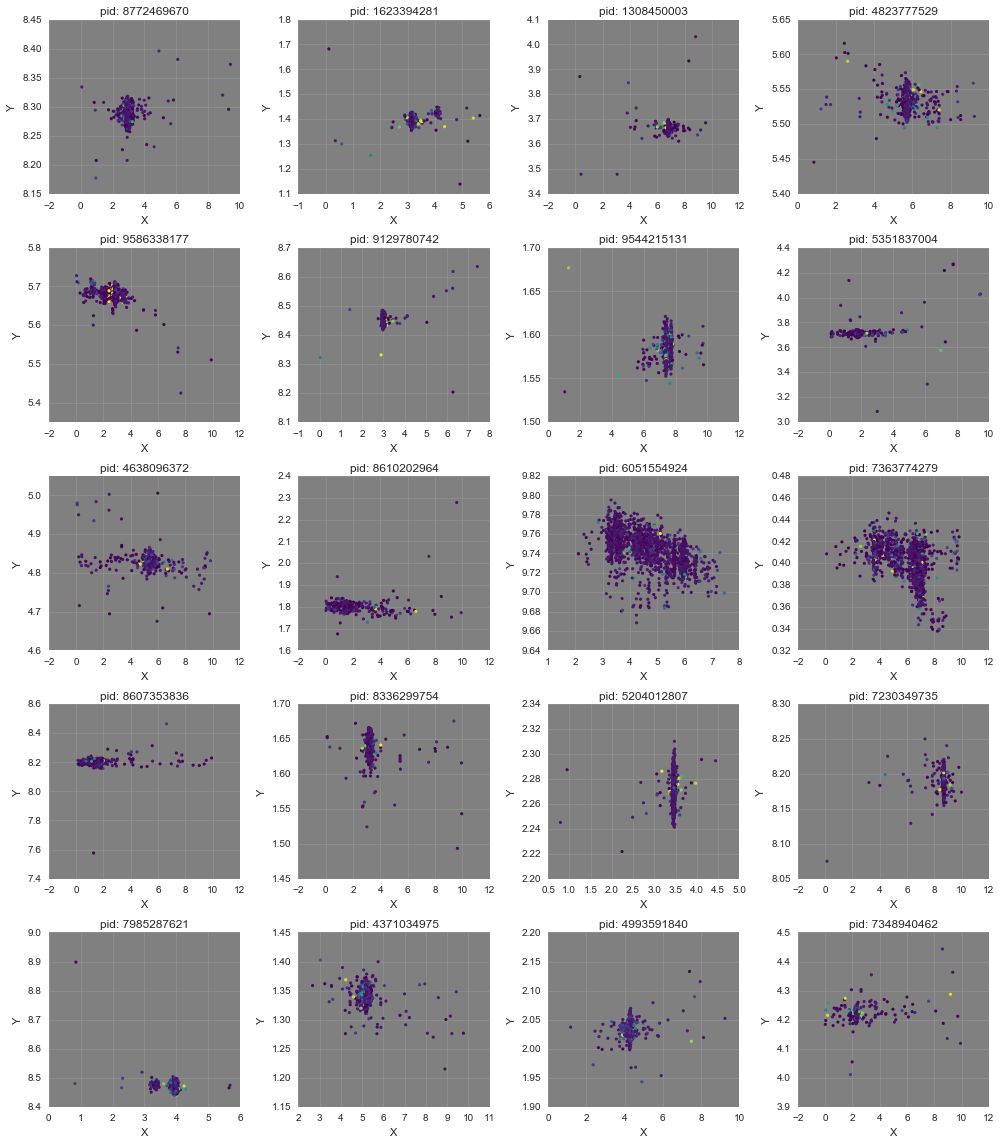

In [20]:
# See if the accuracy varies with distance from centroid point
plt.figure(11, figsize=(14,16))

for i in range(len(l_topplaces)):
    plt.subplot(5,4,i+1)
    plt.gca().set_axis_bgcolor("0.5")
    place = l_topplaces[i]
    df_place = df_train[df_train["place_id"]==place]
    plt.scatter(df_place["x"], df_place["y"], s=10, c=df_place["accuracy"], lw=0, cmap=plt.cm.viridis)
    plt.grid(True, c='0.6', lw=0.5)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("pid: " + str(place))
    
plt.tight_layout()
plt.show()

Nope, not really. What about time variance per location?

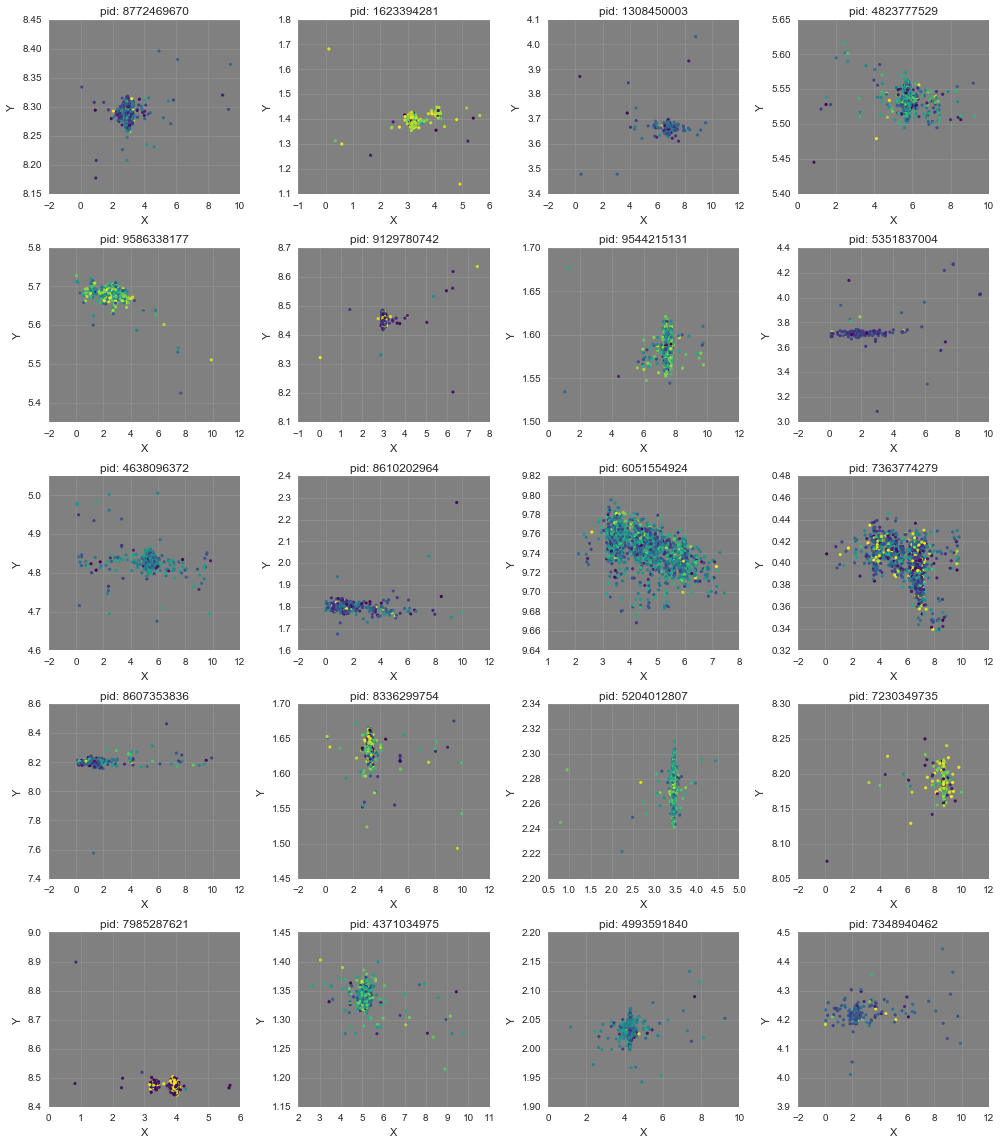

In [21]:
# See if the time varies with distance from centroid point
plt.figure(12, figsize=(14,16))

for i in range(len(l_topplaces)):
    plt.subplot(5,4,i+1)
    plt.gca().set_axis_bgcolor("0.5")
    place = l_topplaces[i]
    df_place = df_train[df_train["place_id"]==place]
    plt.scatter(df_place["x"], df_place["y"], s=10, c=df_place["hour"], lw=0, cmap=plt.cm.viridis)
    plt.grid(True, c='0.6', lw=0.5)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("pid: " + str(place))
    
plt.tight_layout()
plt.show()

This certainly shows different places are preferentially visited at different hours.  
This will be useful for predictions, since for a given "hour" the list of probably places will be reduced.  
Let's pick an arbitrary place, and see if it's shape is discernible over the background noise.

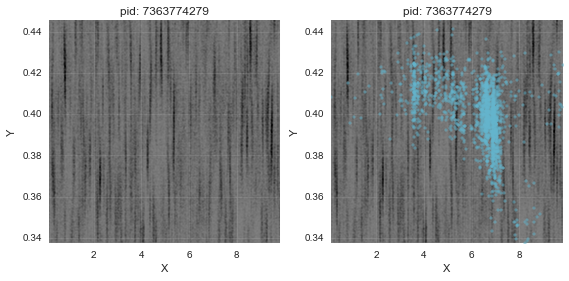

In [22]:
# Pick a place, and see if it's shape profile stands out against background noise (i.e., every other point)
i = 11
place = l_topplaces[i]
df_place = df_train[df_train["place_id"]==place]
xmin, xmax = df_place["x"].min(), df_place["x"].max()
ymin, ymax = df_place["y"].min(), df_place["y"].max()
df_noise = df_train[(df_train["x"]>xmin) &
                    (df_train["x"]<xmax) &
                    (df_train["y"]>ymin) &
                    (df_train["y"]<ymax)]

plt.figure(13, figsize=(8,4))
plt.subplot(121)
plt.gca().set_axis_bgcolor("0.5")
plt.scatter(df_noise["x"], df_noise["y"], s=10, c='k', lw=0, alpha=0.005)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("pid: " + str(place))
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.grid(True, c='0.6', lw=0.5)

plt.subplot(122)
plt.gca().set_axis_bgcolor("0.5")
plt.scatter(df_noise["x"], df_noise["y"], s=10, c='k', lw=0, alpha=0.005)
plt.scatter(df_place["x"], df_place["y"], s=10, c=current_palette[5], lw=0, alpha=0.5)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("pid: " + str(place))
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.grid(True, c='0.6', lw=0.5)

plt.tight_layout()
plt.show()


...not really. OK, let's revisit this x-axis stretching business by visualising these top 20 locations on a map.

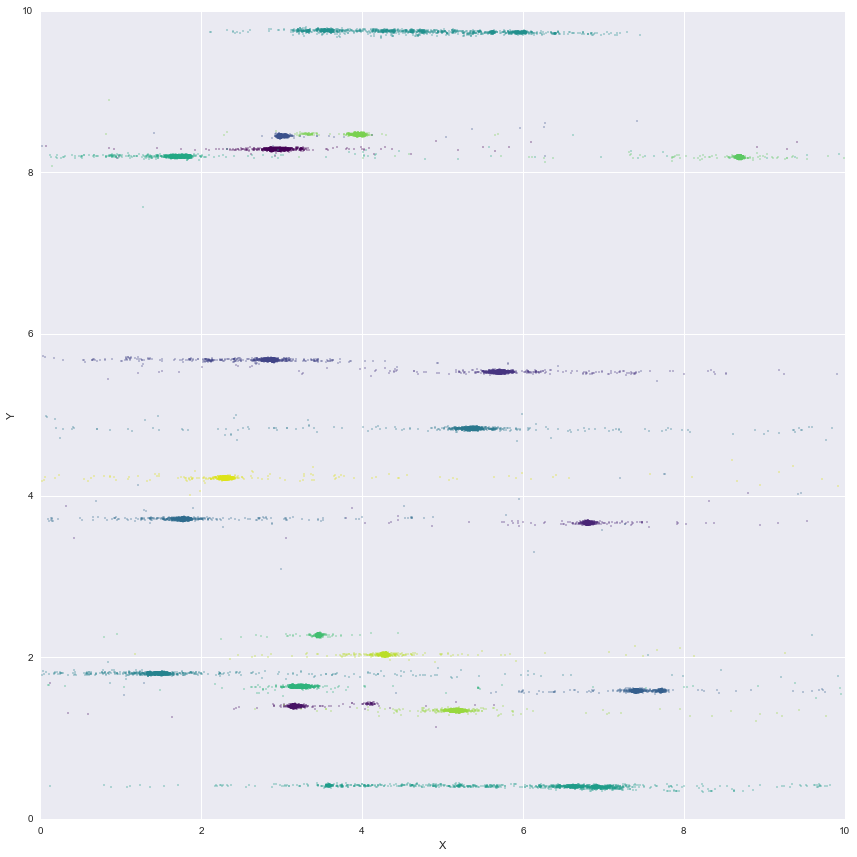

In [23]:
# Go back to the x-axis stretching, and visualise some location checkins on a map
plt.figure(14, figsize=(12,12))

for i in range(20):
    place = l_topplaces[i]
    df_place = df_train[df_train["place_id"]==place]
    plt.scatter(df_place["x"], df_place["y"], s=3, alpha=0.5, c=plt.cm.viridis(int(i*(255/20.))), lw=0)
    
plt.grid(True)
plt.xlabel("X")
plt.ylabel("Y")
plt.tight_layout()
plt.xlim(0,10)
plt.ylim(0,10)
plt.show()

This highlights the variance, looking suspiciously like streets. We can look at the standard deviations to illustrate this:

In [24]:
# Check the stdev of x/y for each place
df_groupplace = df_train.groupby("place_id").agg({"time":"count", "x":"std", "y":"std"})
df_groupplace.sort_values(by="time", inplace=True, ascending=False)
df_groupplace.head()

,y,x,time
place_id,,,
8772469670,0.011544,0.356140,1849
1623394281,0.015712,0.240642,1802
1308450003,0.017662,0.340147,1757
4823777529,0.011860,0.476614,1738
9586338177,0.014817,0.507308,1718


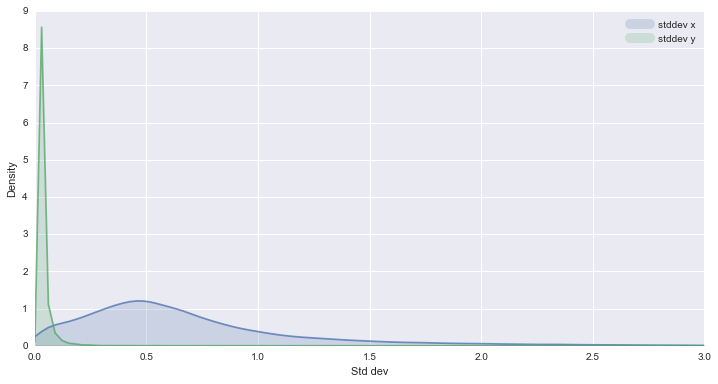

In [25]:
# Density plot
gkde_stddevx = gaussian_kde(df_groupplace["x"][~df_groupplace["x"].isnull()].values)
gkde_stddevy = gaussian_kde(df_groupplace["y"][~df_groupplace["y"].isnull()].values)

# Compute the functions
rangeX = np.linspace(0, 3, 100)
x_density = gkde_stddevx(rangeX)
y_density = gkde_stddevy(rangeX)

plt.figure(15, figsize=(12,6))
plt.subplot(111)
plt.plot(rangeX, x_density, c=current_palette[0], ls="-", alpha=0.75)
plt.plot(rangeX, y_density, c=current_palette[1], ls="-", alpha=0.75)
plt.gca().fill_between(rangeX, 0, x_density, facecolor=current_palette[0], alpha=0.2)
plt.gca().fill_between(rangeX, 0, y_density, facecolor=current_palette[1], alpha=0.2)
plt.ylabel("Density")
plt.xlabel("Std dev")
plt.plot([], [], c=current_palette[0], alpha=0.2, linewidth=10, label="stddev x")
plt.plot([], [], c=current_palette[1], alpha=0.2, linewidth=10, label="stddev y")
plt.legend()
plt.grid(True)

That's pretty striking and will be useful later on.  
Back to time, what if the accuracy varies as a function of hour of day?

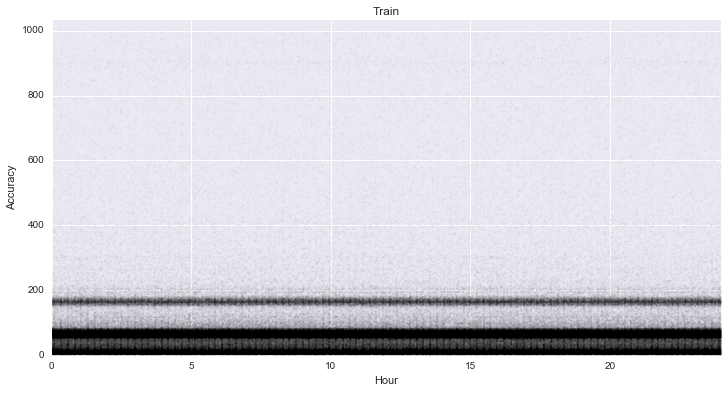

In [26]:
# With the new found time features, we can re-check how accuracy varies with it:
plt.figure(19, figsize=(12,6))
plt.scatter(df_train_sample["hour"], df_train_sample["accuracy"], s=1, c='k', lw=0, alpha=0.05)
plt.xlabel("Hour")
plt.ylabel("Accuracy")
plt.xlim(df_train_sample["hour"].min(), df_train_sample["hour"].max())
plt.ylim(df_train_sample["accuracy"].min(), df_train_sample["accuracy"].max())
plt.title("Train")
plt.show()

Pretty consistent...

## Part 4 - Predictions pre-processing  
One method of determining which place a location might check in to is by looking at the density of points previously used to checkin.  
You could check each point against each density map, and take the maximum.

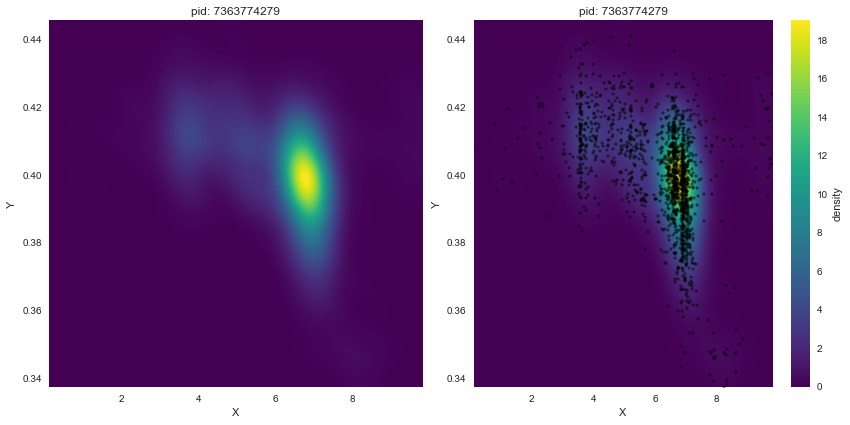

In [27]:

# Try some KDEs, if we can define the density where check-ins are likely, maybe we can assign points based on this
# They will also be time variant
i = 11
place = l_topplaces[i]
df_place = df_train[df_train["place_id"]==place]
xmin, xmax = df_place["x"].min(), df_place["x"].max()
ymin, ymax = df_place["y"].min(), df_place["y"].max()

# Calculate the KDE
res = 200 # resolution
gkde_place = gaussian_kde(np.asarray((df_place["x"], df_place["y"])))
x_flat = np.linspace(xmin, xmax, res)
y_flat = np.linspace(ymin, ymax, res)
x, y = np.meshgrid(x_flat,y_flat)
grid_coords = np.append(x.reshape(-1,1),y.reshape(-1,1),axis=1)
z = gkde_place(grid_coords.T)
z = z.reshape(res,res)

# Plot
extent = [xmin,xmax,ymin,ymax]
plt.figure(20, figsize=(12,6))

# KDE only
plt.subplot(121)
plt.imshow(z[::-1,:],
           extent=extent,
           aspect="auto",
           cmap=plt.cm.viridis,
           interpolation="bilinear")
plt.grid(False)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("pid: " + str(place))
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

# Overplot the points
plt.subplot(122)
plt.imshow(z[::-1,:],
           extent=extent,
           aspect="auto",
           cmap=plt.cm.viridis,
           interpolation="bilinear")
plt.colorbar().set_label("density")
plt.scatter(df_place["x"], df_place["y"], s=10, c='k', lw=0, alpha=0.5)
plt.grid(False)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("pid: " + str(place))
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

plt.tight_layout()
plt.show()

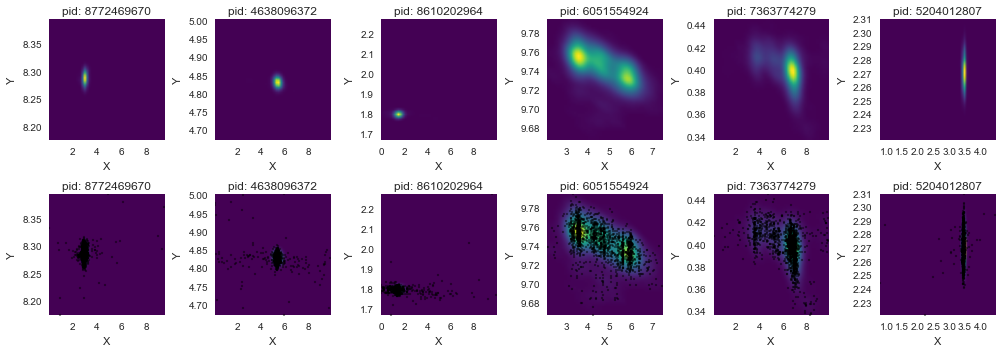

In [28]:
# Try some more
pids = [0,8,9,10,11,14] # A few places
kdes = []
plt.figure(21, figsize=(14,5))
for i in range(len(pids)):
    place = l_topplaces[pids[i]]
    df_place = df_train[df_train["place_id"]==place]
    xmin, xmax = df_place["x"].min(), df_place["x"].max()
    ymin, ymax = df_place["y"].min(), df_place["y"].max()

    # Calculate the KDE
    res = 50 # resolution
    gkde_place = gaussian_kde(np.asarray((df_place["x"], df_place["y"])))
    kdes.append(gkde_place) # Keep these KDEs for later
    x_flat = np.linspace(xmin, xmax, res)
    y_flat = np.linspace(ymin, ymax, res)
    x, y = np.meshgrid(x_flat,y_flat)
    grid_coords = np.append(x.reshape(-1,1),y.reshape(-1,1),axis=1)
    z = gkde_place(grid_coords.T)
    z = z.reshape(res,res)

    # Plot
    extent = [xmin,xmax,ymin,ymax]
    
    # KDE only
    plt.subplot(2,6,i+1)
    plt.imshow(z[::-1,:],
               extent=extent,
               aspect="auto",
               cmap=plt.cm.viridis,
               interpolation="bilinear")
    plt.grid(False)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("pid: " + str(place))
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)

    # Overplot the points
    plt.subplot(2,6,i+7)
    plt.imshow(z[::-1,:],
               extent=extent,
               aspect="auto",
               cmap=plt.cm.viridis,
               interpolation="bilinear")
    plt.scatter(df_place["x"], df_place["y"], s=5, c='k', lw=0, alpha=0.5)
    plt.grid(False)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("pid: " + str(place))
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)

plt.tight_layout()
plt.show()

Next steps?  
- Could try using KDEs of each place to get a metric for each (x,y) location indicating how close to the place it is  
- Play with time offset to try and get more precise definition of hours  
- Use time to eliminate certain places from being possible at given hours  
- Find out what accuracy does  